## Features engineering with NN 😅

Hi there!

In this kernel I followed the now classic path defined by [Nanashi](https://www.kaggle.com/jesucristo/1-smart-robots-complete-notebook-0-73) and tested an approach based on a SVM classifier (bad) and a second (better) on a simple 2 layers keras Neural Network.

The NN approach using small batches should be robust (in theory) to group-vs-surface detection as pointed out by Markus in [The Missing Link...](https://www.kaggle.com/friedchips/the-missing-link)  (just go see this one if you have not already).  

The NN setting:
* Stochastic gradient descent and shuffled training set
* K-Fold
* Dropout layers which have shown an astounding improvement in getting the Train and Validation set accuracy much more consistent

The network model provide `0.77` accuracy on the K-Fold global CV set. **But** When I submit this one I get  a frustrating  `0.34` score on test set: generalization Failed 😅 !

Further inspection of the values from the LeaderBord hack scores are consistent with this behaviour.
Showing that the NN model fail to detect the expected number of surfaces in each category.
Hence this model probably detect the group correctly, but not the surface.

As we are here to learn I make this version public, to push the discussion further.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import sklearn.preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
X_train = pd.read_csv("../input/career-con-2019/X_train.csv")
X_test  = pd.read_csv("../input/career-con-2019/X_test.csv")
y_train = pd.read_csv("../input/career-con-2019/y_train.csv")
y_test73 = pd.read_csv("../input/robots-best-submission/mybest0.73.csv")


le = sklearn.preprocessing.LabelEncoder().fit(y_train['surface'])
le.classes_

## Conversion quaternions -> Euler angles

Reusing code snipet from kernel [#1 Smart Robots. Complete Notebook 🤖 [0.73]](https://www.kaggle.com/jesucristo/1-smart-robots-complete-notebook-0-73) and improve it with numpy vectorization support

![](https://flowvisioncfd.com/webhelp/fven_30905/object_prop_ship__e_zoom41.png)
Image credit: flowvisioncfd.com (idea by Nanashi)

In [ ]:
# https://stackoverflow.com/questions/53033620/how-to-convert-euler-angles-to-quaternions-and-get-the-same-euler-angles-back-fr?rq=1
def quaternion_to_euler(x, y, z, w):
    """Function refactored to accept np.array as inputs for faster processing"""
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = np.arctan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2[t2>+1.0] = +1.0
    t2[t2<-1.0] = -1.0
    Y = np.arcsin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = np.arctan2(t3, t4)

    return X, Y, Z

# conversion for train and test
for df in X_train, X_test:
    X, Y, Z = quaternion_to_euler(df.orientation_X, df.orientation_Y,df.orientation_Z, df.orientation_W)
    df['X'] = X
    df['Y'] = Y
    df['Z'] = Z

## Build features from time domain data

In [ ]:
###################################################################
##########  Hyper Parameters
###################################################################

# columns to build features on
COLUMNS = [ 'X', 'Y', 'Z', 
           'angular_velocity_X',    'angular_velocity_Y',    'angular_velocity_Z', 
           'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z' ]

# NN parameters
EPOCHS=100
BS=32
INIT_LR=0.001
DROPOUT=0.1


In [ ]:
X_test.series_id
df_features_train = pd.DataFrame()
df_features_test  = pd.DataFrame()

def add_columns(df_in, df_out, op):
    for column in COLUMNS:
        df_out[f"{column}_{op}"] = df_in[column]

for (df_data, df_features) in [(X_train, df_features_train), (X_test, df_features_test)]:
    grp = df_data.groupby('series_id')[COLUMNS]
    df_op = grp.mean()
    add_columns(df_op, df_features, "mean")    
    df_op = grp.median()
    add_columns(df_op, df_features, "median")
    df_op = grp.std()
#    add_columns(df_op, df_features, "std")
#    df_op = grp.quantile(0.25)
    add_columns(df_op, df_features, "q25")
    df_op = grp.quantile(0.80)
    add_columns(df_op, df_features, "q75")
df_features_test.head()

In [ ]:
f,ax = plt.subplots(figsize=(14, 14))
sns.heatmap(df_features_train.iloc[:,1:].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, cmap='jet')
plt.title('TRAIN')


In [ ]:
f,ax = plt.subplots(figsize=(14, 14))
sns.heatmap(df_features_test.iloc[:,1:].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, cmap='jet')
plt.title('TEST')

## Train SVC (bad) model

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=777)
X, y = df_features_train.values, le.transform(y_train.surface.values)
scaler.fit(X)
X = scaler.transform(X)
for idx_tr, idx_cv in sss.split(X, y):
    model = SVC(kernel='rbf', gamma=0.08)
    model.fit(X[idx_tr], y[idx_tr])

pred_tr = model.predict(X[idx_tr])
pred_cv = model.predict(X[idx_cv])

print("Accuracy on TRAIN set =", accuracy_score(y[idx_tr], pred_tr))
print("Accuracy on CV    set =", accuracy_score(y[idx_cv], pred_cv))

pred_test = model.predict(scaler.transform(df_features_test.values))
print("Test73 CMP =", accuracy_score(y_test73.surface.values, le.inverse_transform(pred_test)))

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion(y0, y1, title):
    cnf_matrix = confusion_matrix(y0, y1)
    cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cnf_matrix_norm, index=le.classes_, columns=le.classes_)

    plt.figure(figsize=(20, 7))
    ax = plt.axes()
    ax.set_title(title, fontsize='18')
    sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
    plt.show()
    
plot_confusion(y[idx_tr], pred_tr,'Train set for SVC model')
plot_confusion(y[idx_cv], pred_cv,'CV set for SVC model')


## NN (better) model definition

In [ ]:

import keras
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import *
from keras.models import Model, Sequential
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.regularizers import l1, l2

def build_NN(width, classes, init_lr=INIT_LR, epochs=EPOCHS):
    l2reg = l2(0.001)
    
    # initialize the model
    model = Sequential()
    inputShape = (width,)

    
    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dropout(rate=DROPOUT, input_shape=inputShape))
    model.add(Dense(width, activation='linear'))#, kernel_regularizer=l2reg))
    model.add(Activation("relu"))

    model.add(Dense(width, activation='linear'))#, kernel_regularizer=l2reg))
    model.add(Activation("relu"))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    opt   = Adam(lr=init_lr, decay=init_lr / epochs)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["categorical_accuracy"])

    # return the constructed network architecture
    return model

def kreshape(X):
    return np.reshape(X, np.concatenate([X.shape, [1]]))

model = build_NN(X.shape[1], len(le.classes_))

#history = model.fit(kreshape(X[idx_tr]), to_categorical(y[idx_tr]), 
#              epochs=EPOCHS, batch_size=BS, verbose=0,
#              validation_data=[kreshape(X[idx_cv]), to_categorical(y[idx_cv])])

## Run K-Fold

In [ ]:
from sklearn.model_selection import StratifiedKFold

def k_folds(X, y, X_test, k=5):
    folds = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=777).split(X, y))
    y_test = np.zeros((X_test.shape[0], len(COLUMNS)))
    y_gcv  = np.zeros((X.shape[0], len(COLUMNS)))
    histories = []
    
    for i, (train_idx, val_idx) in  enumerate(folds):
        print(f"Fold {i+1}")
        model = build_NN(X.shape[1], len(le.classes_))

        try:
            history = model.fit(kreshape(X[train_idx]), to_categorical(y[train_idx]),  
                                validation_data=[kreshape(X[val_idx]), to_categorical(y[val_idx])], 
                                batch_size=BS, epochs=EPOCHS, verbose=0)
        except Exception as e:
            model.summary()
            raise e
        histories.append(history)
        
        pred_cv = model.predict(kreshape(X[val_idx]))
        y_gcv[val_idx]   += pred_cv 
        score  = accuracy_score(np.argmax(pred_cv, axis=1), y[val_idx])
        print(f'Scored {score:.3f} on validation data')
        
        y_test += model.predict(kreshape(X_test))
        
    return histories, model, np.argmax(y_test, axis=1), np.argmax(y_gcv, axis=1)

histories, kmodel, pred_test_kfold, pred_gcv= k_folds(X, y, scaler.transform(df_features_test.values) )
#history = model.fit(kreshape(X[idx_tr]), to_categorical(y[idx_tr]), 
#              epochs=EPOCHS, batch_size=BS, verbose=0,
#              validation_data=[kreshape(X[idx_cv]), to_categorical(y[idx_cv])])

## Learing metrics

In [ ]:
pred_train  = np.argmax(kmodel.predict(kreshape(X)), axis=1)
score_train = accuracy_score(pred_train, y)
print(f'Global score {score_train:.3f} on TRAIN data')

score_gcv = accuracy_score(pred_gcv, y)
print(f'Global Kfold {score_gcv:.3f} on CV data')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
for history in histories:
    history_pd = pd.DataFrame.from_dict(history.history)
    history_pd[['loss', 'val_loss']].plot(kind='line', ax=ax1 )
    history_pd[['categorical_accuracy', 'val_categorical_accuracy']].plot(kind='line', ax=ax2)
ax1.set_yscale('log')

plot_confusion(y, pred_train,'Full Train set for NN')
plot_confusion(y, pred_train,'KFold CV set for NN')


**Note**:

bellow I've added
* The global train score form NN model applyied in full training set
* The global CV score which is a KFold by-product
* The 0.73 values from Nanashi demonstrating how a 0.73 classifier behaves
* the pretty cool [Public leaderboard distribution](https://www.kaggle.com/c/career-con-2019/discussion/84760) hack values for comparison.

In [ ]:
le.classes_

3816
Test73 CMP = 0.4811320754716981
Estimated max accuracy for TEST set from LB hack: 0.42489580712788266


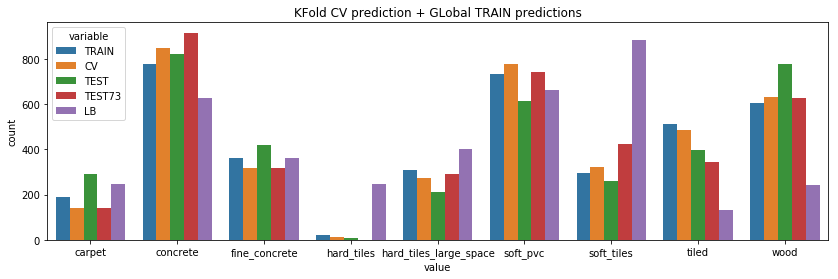

In [70]:
ntest = 3816
LB_ratio = {
    'carpet':0.065,
    'concrete':0.165,
    'fine_concrete': 0.095,
    'hard_tiles': 0.065,
    'hard_tiles_large_space': 0.105,
    'soft_pvc':   0.174,   #  values slightly tweaked
    'soft_tiles': 0.2321, #  to get nexamples total
    'tiled': 0.035,
    'wood': 0.065,
}
LB = np.concatenate( [ [surf]*int(LB_ratio[surf]*ntest) for surf in LB_ratio] )
print(LB.size)

fig = plt.figure(figsize=(14,4))
df_count=pd.DataFrame({'TRAIN':y_train.surface, 
                       'CV':le.inverse_transform(pred_gcv),
                       'TEST':le.inverse_transform(pred_test_kfold[0:3810]),
                       'TEST73':y_test73.surface[0:3810],
                       'LB':LB[0:3810]})
sns.countplot(x='value', hue='variable', data=pd.melt(df_count), order=le.classes_, )
plt.title("KFold CV prediction + GLobal TRAIN predictions")


print("Test73 CMP =", accuracy_score(y_test73.surface.values, le.inverse_transform(pred_test_kfold)))

print("Estimated max accuracy for TEST set from LB hack:",
     1.0 - np.sum([ np.abs(LB_ratio[surf] - 
                           np.sum(pred_test_kfold==le.transform([surf]))/len(pred_test_kfold))
                    for surf in LB_ratio ]))


In [ ]:
df = pd.read_csv("../input/career-con-2019/sample_submission.csv")
df['surface'] = le.inverse_transform(pred_test_kfold)
df.to_csv('submission.csv', index=False)
df.head()

In [ ]:
y_test73.head()